<h1> Ship Type Prediction </h1>

<p align='justify'>

This Jupyter notebook contains a classification example which is
done with the help of Scikit-Learn library. In this notebook,
the following steps are performed:
</p>

<ol align='justify'>
    <li> The preprocessing i.e. feature generation, filtering and
         interpolation of the data is carried out using the
         PTRAIL Library.
    </li>
    <li> Further, several models like RandomForestClassifier, KMeans
         Classifier etc. are trained using the Scikit-Learn library
         based on the cleaned dataset.
    </li>
    <li>
        Finally, on the interpolated dataset, the type of ships are
        predicted and their accuracy is checked.
    </li>

In [1]:
# We are going to supress any UserWarnings for demonstration purposes.
import warnings
warnings.simplefilter("ignore", UserWarning)

# Load the data into a pandas dataframe and convert it into a PTRAILDataFrame.
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics

pdf = pd.read_csv('https://raw.githubusercontent.com/YakshHaranwala/PTRAIL/main/examples/data/ships.csv')
ships_df = PTRAILDataFrame(data_set=pdf,
                           latitude='lat',
                           longitude='lon',
                           datetime='Timestamp',
                           traj_id='Name')

# Filter out only Cargo, passenger and fishing ships.
ships = ships_df.loc[ships_df['ShipType'].isin(['Cargo', 'Passenger', 'Fishing'])]

# Change the labels of the ShipTypes to the following:
# Cargo: 0
# Fishing: 1
# Passenger: 2
ships['ShipType'] = ships['ShipType'].map({'Cargo': 0, 'Fishing': 1,'Passenger': 2,})
ships = PTRAILDataFrame(data_set=ships.reset_index(),
                        latitude='lat',
                        longitude='lon',
                        datetime='Timestamp',
                        traj_id='Name')

ships.head()

lat        lon       MMSI  \
traj_id      DateTime                                               
ALVSNABBEN 3 2017-05-07 04:53:52  11.911787  57.696630  265547220   
             2017-05-07 04:54:11  11.911037  57.695727  265547220   
             2017-05-07 04:54:18  11.910832  57.695447  265547220   
             2017-05-07 04:54:24  11.910637  57.695108  265547220   
             2017-05-07 04:54:51  11.910442  57.693890  265547220   

                                               NavStatus   SOG    COG  \
traj_id      DateTime                                                   
ALVSNABBEN 3 2017-05-07 04:53:52  Under way using engine  10.6  204.5   
             2017-05-07 04:54:11  Under way using engine  10.8  203.1   
             2017-05-07 04:54:18  Under way using engine  10.9  201.6   
             2017-05-07 04:54:24  Under way using engine  10.9  197.9   
             2017-05-07 04:54:51  Under way using engine   9.4  177.2   

                                  ShipType  
traj_id      DateTime                       
ALVSNABBEN 3 2017-05-07 04:53:52         2  
             2017-05-07 04:54:11         2  
             2017-05-07 04:54:18         2  
             2017-05-07 04:54:24         2  
             2017-05-07 04:54:51         2

In [2]:
%%time

from ptrail.features.kinematic_features import KinematicFeatures
from ptrail.preprocessing.filters import Filters
from ptrail.preprocessing.interpolation import Interpolation
from ptrail.preprocessing.statistics import Statistics

# Generate Kinematic Features first
feature_df = KinematicFeatures.generate_kinematic_features(dataframe=ships)

# Hampel Filter based on Distance and Speed.
dist_filter = Filters.hampel_outlier_detection(dataframe=feature_df, column_name='Distance')
speed_filter = Filters.hampel_outlier_detection(dataframe=dist_filter, column_name='Speed')

# Cubic Interpolation with a sampling rate of 15 minutes.
cubic_ip = Interpolation.interpolate_position(dataframe=speed_filter, sampling_rate=15,
                                              ip_type='cubic' ,class_label_col='ShipType')

# Finally, generating Kinematic stats and pivoting the dataframe to get it ready for classification.
stats_df = Statistics.generate_kinematic_stats(dataframe=cubic_ip, target_col_name='ShipType',segmented=False)
pivoted_df = Statistics.pivot_stats_df(dataframe=stats_df, target_col_name='ShipType', segmented=False)

pivoted_df

CPU times: user 1.27 s, sys: 285 ms, total: 1.56 s
Wall time: 12 s


,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,ShipType
traj_id,,,,,,,,,,,,,,,,,,,,,
FROJA,0.057055,0.133375,0.293750,1.194122,44.313517,0.000000,1157.803878,12.488872,39.071747,0.638253,...,-11.872005,-2.285599,0.000000,2.425476,11.088195,-180.000000,118.832095,-0.225616,14.784591,2
SKARVEN,0.078122,0.200548,0.903125,36.393834,87.363078,0.000000,2107.590139,30.134360,75.080031,1.106070,...,-4.724440,-0.667541,0.000000,0.797145,4.408457,-207.553783,118.364800,-0.280690,14.675692,2
YLVA,0.164904,0.812340,26.577705,64.903118,123.493286,0.000000,1330.321991,50.119373,89.267114,780.096574,...,-2.695783,-0.419236,-0.003525,0.413282,2.938319,-241.730513,178.621340,-0.434594,17.903880,2
VESTA,0.274423,9.671358,33.106043,62.317431,114.961674,0.000000,1060.472414,48.724350,65.239187,1114.793624,...,-1.434853,-0.315043,0.000976,0.344046,2.281764,-339.403064,118.670187,-0.217645,22.111720,2
STENA JUTLANDICA,23.763272,30.303500,65.197338,95.209987,125.507815,0.000000,690.878618,71.704969,53.996978,937.647677,...,-0.132282,-0.031366,0.000956,0.026817,0.117055,-152.640411,19.053099,-0.132564,4.858760,2
STENA DANICA,23.908271,29.470549,59.716101,89.546077,124.308272,5.712908,384.786142,68.007574,47.529736,872.701679,...,-0.143050,-0.037826,-0.001931,0.032265,0.154365,-144.469163,2.197280,-0.242167,5.485089,2
MAGNOLIA SEAWAYS,0.009723,0.567523,2.044154,12.221367,31.073395,0.000000,179.737033,11.873302,23.631588,1985.088510,...,-15.000000,-1.211999,0.000000,1.395949,12.008213,-106.720627,119.998168,0.168447,15.390393,0
ALVSNABBEN 5,8.294584,15.555204,22.786692,41.356637,66.639445,0.000000,299.439467,33.373663,33.593336,72.708494,...,-3.590856,-0.985806,0.054550,0.934058,2.614244,-98.405128,76.641322,-0.520147,8.942776,2
BEGONIA SEAWAYS,0.000000,0.077296,0.240258,2.481021,32.583736,0.000000,423.479245,10.790732,32.128209,3571.814231,...,-16.124610,-1.294499,0.000000,1.993653,14.112805,-180.000000,180.000000,-1.171904,22.229874,0


In [3]:
# Step-5: Getting the test and train datasets ready.
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


X_train, X_test, y_train, y_test = train_test_split(pivoted_df.drop(columns=['ShipType']),
                                                    pivoted_df['ShipType'],
                                                    random_state=7, test_size=0.2)

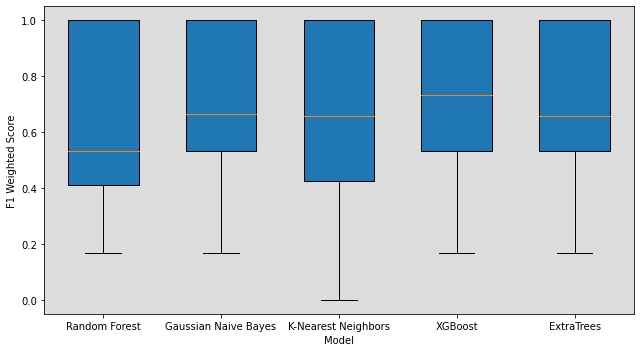

In [4]:
# Let's visualize the scores using box plot of cross validation of the models.
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

names = ["Random Forest", "Gaussian Naive Bayes", "K-Nearest Neighbors", "XGBoost", "ExtraTrees"]
models = [
    RandomForestClassifier(n_estimators=300, criterion='gini', max_features='log2',),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', n_jobs=-1, algorithm='kd_tree'),
    GradientBoostingClassifier(n_estimators=500, max_features='log2',),
    ExtraTreesClassifier(n_estimators=500, criterion='gini', max_features='log2', n_jobs=-1, class_weight='balanced')
]

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=10)
for i, name, model in zip(range(0, 5), names, models):
    scores = cross_val_score(model, pivoted_df.drop(columns=['ShipType']), pivoted_df['ShipType'],
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i], vert=True,
               widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("F1 Weighted Score")
ax.set_xlabel("Model")
plt.tight_layout()